In [112]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as am
from scipy.optimize import curve_fit

In [119]:
def extract_lite(realisation): 
    total_active = [] 
    total_tracer = [] 
    tracer_snapshot = np.zeros((L, L)) 
    tracer_moments = [] 
    time = [] 
    flag = False 
    passive_indices = [] 

    for line in realisation:  
        if line.startswith('time'):
            time.append(float(line[5:-1]))
        elif line.startswith('total active'):
            total_active.append(float(line[13:-1]))
        elif line.startswith('total tracer'):
            total_tracer.append(float(line[13:-1]))
        elif line.startswith('passive'):
            passive_indices = np.fromstring(line[8:-1], sep=',')
            passive_indices = np.unravel_index(passive_indices.astype('int'), (L, L))
        elif line.startswith('coarse_grain_tracer'):
            flag = True 
        elif flag: 
            tracer_moments.append(np.fromstring(line, sep=','))
    
    tracer_snapshot[passive_indices] = 1 # set occupied sites to -1     
    return time, total_active, total_tracer, tracer_snapshot, np.vstack(tracer_moments)

def extract_moments(moments): 
    active_moments = [] 
    tracer_moments = [] 
    active_flag = False 
    tracer_flag = False 
    
    for line in moments: 
        if line.startswith(' active moments'):
            active_flag = True 
        elif line.startswith('tracer moments'):
            active_flag = False 
            tracer_flag = True 
        else: 
            if active_flag: 
                active_moments.append(np.fromstring(line, sep='\t'))
            if tracer_flag: 
                tracer_moments.append(np.fromstring(line, sep='\t'))
    return np.vstack(active_moments), np.vstack(tracer_moments)
        
def extract_evolution(realisation): 
    tracers = []
    active_particles = [] 
    edges = [] 
    msds = [] 
    total_active = [] 
    total_tracer = [] 
    time = [] 
    passive_flag = False 
    active_flag = False
    for line in realisation:  
        if line.startswith('time'):
            time.append(float(line[5:-1]))
        elif line.startswith('total active'):
            total_active.append(float(line[13:-1]))
        elif line.startswith('total tracer'):
            total_tracer.append(float(line[13:-1]))
        elif line.startswith('passive'):
            passive_indices = np.fromstring(line[8:-1], sep=',')
            passive_indices = np.unravel_index(passive_indices.astype('int'), (L, L))
            passive_flag = True 
        elif line.startswith('active'):
            active_indices = np.fromstring(line[7:-1], sep=',')
            active_indices = np.unravel_index(active_indices.astype('int'), (L, L))
            active_flag = True 
        elif line.startswith('msd'):
            msds.append(float(line[4:-1]))
        elif line.startswith('edge'): 
            edges.append(np.fromstring(line[5:-1], sep=','))
        else: 
            tracer_snapshot = np.zeros((L, L)) # clear the snapshot for the next time slice 
            active_snapshot = np.zeros((L, L)) 
            
        if passive_flag and active_flag: 
            tracer_snapshot[passive_indices] = 1 # set occupied sites to -1 
            
            for (i,j) in zip(*active_indices):
                active_snapshot[i, j] += 1 
            tracers.append(tracer_snapshot)
            active_particles.append(active_snapshot)
            passive_flag = False 
            active_flag = False 
            
    return np.array(edges), np.array(msds), np.array(counts), np.array(tracers), np.array(active_particles)

def make_movies(evolution, label):
    fig = plt.figure(figsize=(20, 20))
    ims = []
    plt.axis('off')
    for xy in evolution:
        im = plt.imshow(xy, animated=True, vmin=0, vmax=2, cmap='Blues', origin='lower') 
        plt.axis('off')
        ims.append([im])
        
    ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    mywriter = am.FFMpegWriter()
    ani.save("{}_movie_{}.mp4".format(label, i), writer=mywriter)
    plt.close()  
    
    
def pad(nested_lists): 
    max_length = max(map(len, nested_lists))
    for l in nested_lists: 
        length = len(l)
        if length == 0: 
            raise Exception('no time series data recorded')
        elif length < max_length: 
            l.extend([l[-1]]*(max_length-length))
    return np.vstack(nested_lists)

def select_longest(times): 
    return max(times, key=lambda x:len(x))

def powerlaw_fx(x, a, b, m):
	return a + b*x**m    
    

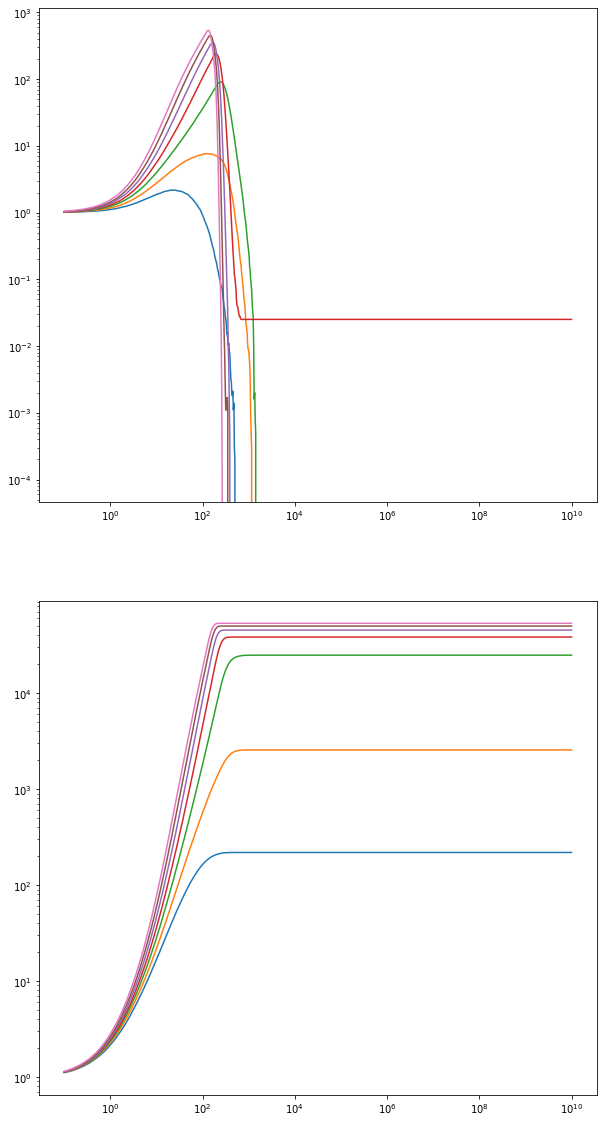

In [127]:
L = 257
N = 10000
hs = (0.2,0.3,0.4,0.5,0.6,0.7,0.8)
p = 0.6
q = 0.2
#  (1-p-2q)^2 + p^2 + 2*q^2 + (1-p-2q)*(p+2q)

_, axes = plt.subplots(2, figsize=(10, 20))
exps = []    
for (i,h) in enumerate(hs):

    label = 'L'+str(L)+'_N'+str(N)+'_p'+str(p)+'_q'+str(q)+'_h'+str(h)
    file = open("data_{}.dat".format(label))

    realisations = []
    moments = [] 
    realisation_flag = False 
    moments_flag = False

    n = 0 
    line = file.readline() 
    while line: 
        if line[0] == '#':
            # print(line)
            if line.startswith('# Starting'):
                realisation_flag = True 
            if line.startswith('#Writing'): 
                moments_flag = True 
        else: 
            if moments_flag: 
                moments.append(line)
            elif realisation_flag: 
                new_realisation = [line]
                realisations.append(new_realisation)
                realisation_flag = False
            else:
                new_realisation.append(line)   
        line = file.readline()
        
    # print(moments)
    active_moments, tracer_moments = extract_moments(moments)
    axes[0].plot(tracer_moments[:, 0],active_moments[:, 2]/N)
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    # axes[0].set_xlim([0.1,20])
    # axes[0].set_ylim([1,3])
    axes[1].plot(tracer_moments[:, 0],tracer_moments[:, 2]/N)
    # fit powerlaw
    t = tracer_moments[:, 0]
    mom = tracer_moments[:, 2]
    xfit = t[(t>=2) & (t<=3)]
    yfit = mom[(t>=2) & (t<=3)]
    # [popt,pcov] = curve_fit(powerlaw_fx,xfit,yfit,p0 = [1,1,1])
    # axes[1].plot(xfit,powerlaw_fx(xfit,*popt))
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    # axes[1].set_xlim([0.1,20])
    # exps[i] = popt[2]


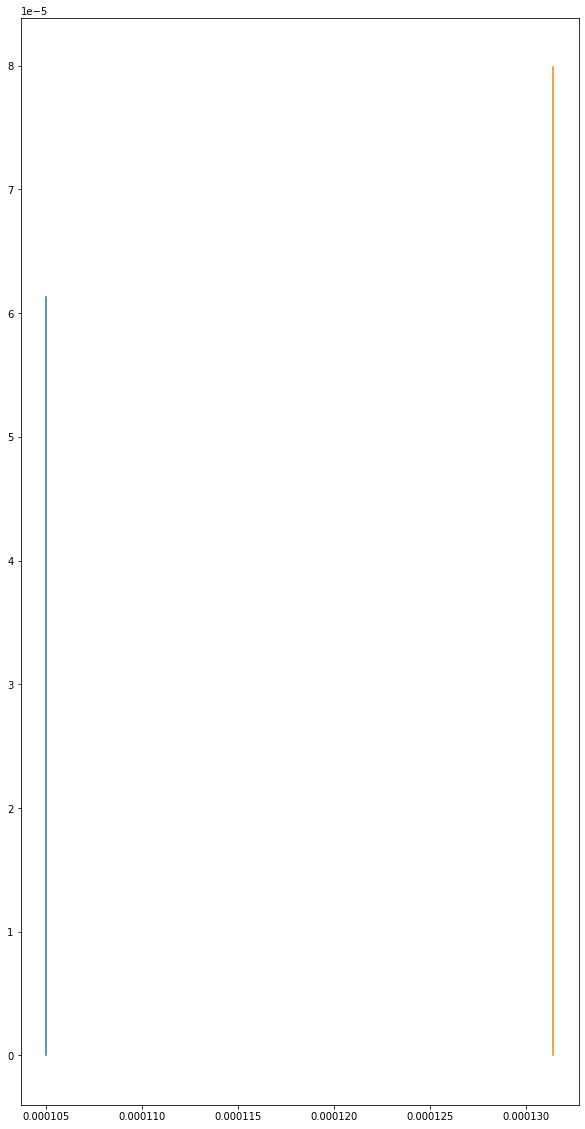

In [96]:
L = 257
N = 10000
hs = (0.2,0.3) # (0.2,0.3,0.4,0.5,0.6,0.7,0.8)
p = 0.25
q = 0.25

_, axes = plt.subplots(1, figsize=(10, 20))
    
for h in hs:

    label = 'L'+str(L)+'_N'+str(N)+'_p'+str(p)+'_q'+str(q)+'_h'+str(h)
    file = open("data_{}.dat".format(label))

    realisations = []
    moments = [] 
    realisation_flag = False 
    moments_flag = False

    n = 0 
    line = file.readline() 
    while line: 
        if line[0] == '#':
            # print(line)
            if line.startswith('# Starting'):
                realisation_flag = True 
            if line.startswith('#Writing'): 
                moments_flag = True 
        else: 
            if moments_flag: 
                moments.append(line)
            elif realisation_flag: 
                new_realisation = [line]
                realisations.append(new_realisation)
                realisation_flag = False
            else:
                new_realisation.append(line)   
        line = file.readline()

    actives = [] 
    tracers = [] 
    tracer_snapshots = [] 
    times = [] 
    box_size = []
    giant_mean = []
    giant_std = []


    for (i, realisation) in enumerate(realisations):

        time, total_active, total_tracer, tracer_snapshot, tracer_moment = extract_lite(realisation)
        times.append(time)
        actives.append(total_active)
        tracers.append(total_tracer)
        tracer_snapshots.append(tracer_snapshot)
        box_size = tracer_moment[:,0]
        giant_mean.append(tracer_moment[:,1])
        giant_std.append(tracer_moment[:,2])
    
    gnf_mean = np.mean(giant_mean,0)
    gnf_std = np.mean(giant_std,0)
    axes.plot(gnf_mean,gnf_std)

    # t_array = select_longest(times)
    # actives = pad(actives)
    # tracers = pad(tracers)
        
    # for (i, n) in enumerate(range(1, 6)): 
    #     m = np.mean(tracer_moment, axis=0)
    #     axes[i].plot(t_array, m)
    # #     axes[i].set_xscale('log')


   

In [97]:
# giant_mean.append(tracer_moment[:,1])
# gnf_std = np.mean(giant_std,0)
print(gnf_mean)


[0.0001314 0.0001314 0.0001314 0.0001314 0.0001314 0.0001314 0.0001314]


In [133]:
p = 0.33
q = 0.33
print((1-p-2*q)**2 + p**2 + 2*q**2 + (1-p-2*q)*(p+2*q))

0.33669999999999994
